# Mock SFH data
In this notebook, I will generate mock data that I will use to demonstrate the prior correction method. The mock data will be generated using FSPS with $M_*=10^{10}M_\odot$, $Z = 0.02$, and with the following different SFHs: 
1. constant
2. falling
3. rising
4. burst
5. quench

In [2]:
import os
import numpy as np 
import fsps
from astropy.cosmology import Planck13

In [58]:
# --- plotting --- 
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [5]:
tage = Planck13.age(0.).value # Gyr age of z=0 galaxy

## get SFHs

In [43]:
nlb = 1000 # look back time bins
tlb = np.linspace(0, tage, nlb) # look back time

# delta t bin widths
dt = np.zeros(nlb)
dt[1:-1] = 0.5 * (np.diff(tlb)[1:] + np.diff(tlb)[:-1]) 
dt[0]   = 0.5 * (tlb[1] - tlb[0]) 
dt[-1]  = 0.5 * (tlb[-1] - tlb[-2]) 

In [31]:
sfh_constant = np.ones(nlb)/np.trapz(np.ones(nlb), tlb)
sfh_falling = np.exp((tlb-tage)/1.4)/np.trapz(np.exp((tlb-tage)/1.4), tlb)
sfh_rising = np.exp((tage-tlb)/3.4)/np.trapz(np.exp((tage -tlb)/3.4), tlb)
sfh_burst = 0.8*(np.ones(nlb)/np.trapz(np.ones(nlb), tlb)) + 0.2 * (np.exp(-0.5*(tlb - 0.5)**2/0.2**2)/np.trapz(np.exp(-0.5*(tlb - 0.5)**2/0.2**2), tlb))
sfh_quench = np.concatenate([0.02*np.ones(nlb)[tlb < 1], np.ones(nlb)[tlb >= 1]])/np.trapz(np.concatenate([0.02*np.ones(nlb)[tlb < 1], np.ones(nlb)[tlb >= 1]]), tlb)

In [34]:
sfhs = [sfh_constant, sfh_falling, sfh_rising, sfh_burst, sfh_quench]
lbls = ['constant', 'falling', 'rising', 'burst', 'quench']

In [46]:
# check that the SFH are normalized properly
for sfh in sfhs: 
    assert np.isclose(np.trapz(sfh, tlb), 1.)

Text(0.5, 0, '$t_{\\rm lookback}$ [Gyr]')

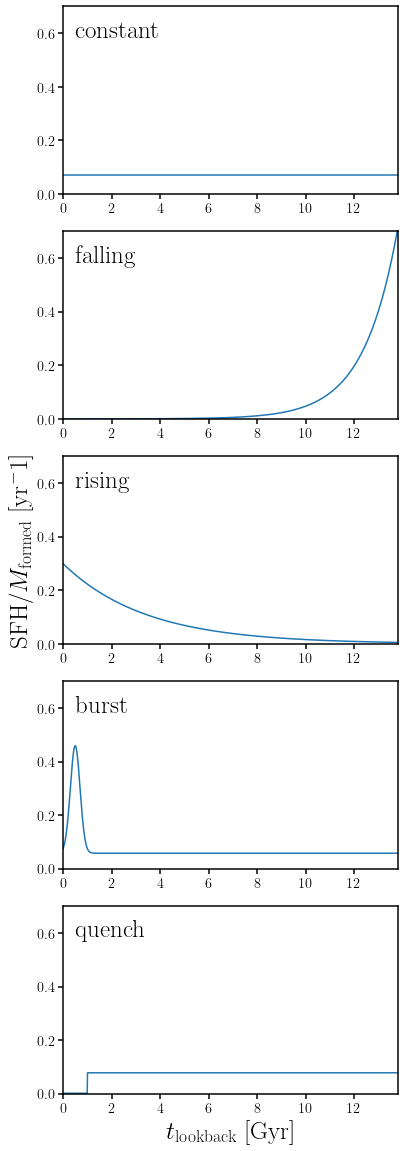

In [56]:
fig = plt.figure(figsize=(6,20))
for i, sfh, lbl in zip(range(5), sfhs, lbls): 
    sub = fig.add_subplot(5,1,i+1)
    sub.plot(tlb, sfh, c='C0', label=lbl)
    sub.set_xlim(0, tage)
    if i == 2: sub.set_ylabel(r'SFH/$M_{\rm formed}$ [${\rm yr}^-1$]', fontsize=25)
    sub.set_ylim(0, 0.7)
    sub.text(0.5, 0.65, lbl, ha='left', va='top', fontsize=25)
sub.set_xlabel(r'$t_{\rm lookback}$ [Gyr]', fontsize=25)

# construct SEDs using `fsps`
First, initiate a `fsps.StellarPopulation` object

In [42]:
ssp = fsps.StellarPopulation(
    zcontinuous=1, # interpolate metallicities
    sfh=0,         # tabulated SFH 
    dust_type=2,   # calzetti(2000)
    imf_type=1)    # chabrier IMF 

In [53]:
def build_SED(sfh): 
    ''' construct SED given tabulated SFH using FSPS. All SEDs
    have Z = Zsol and dust2 = 
    
    '''
    mtot = 0.
    for i, tage in enumerate(tlb): 
        m = dt[i] * sfh[i] # mass formed in this bin 
        if m == 0 and i != 0: continue 

        ssp.params['logzsol'] = 0 
        ssp.params['dust2'] = 0.3 # tau_V (but Conroy defines tau differently than standard methods)

        wave_rest, lum_i = ssp.get_spectrum(
                tage=np.clip(tage, 1e-8, None), 
                peraa=True) # in units of Lsun/AA
        
        # note that this spectrum is normalized such that the total formed
        # mass = 1 Msun
        if i == 0: lum_ssp = np.zeros(len(wave_rest))
        lum_ssp += m * lum_i 
        mtot += m
    assert np.isclose(mtot, 1.)
        
    lum_ssp *= 10**10 # 10^10 Msun
    return wave_rest, lum_ssp

In [55]:
sed_constant = build_SED(sfh_constant)
sed_falling = build_SED(sfh_falling)
sed_rising = build_SED(sfh_rising)
sed_burst = build_SED(sfh_burst)
sed_quench = build_SED(sfh_quench)

In [60]:
seds = [sed_constant, sed_falling, sed_rising, sed_burst, sed_quench]

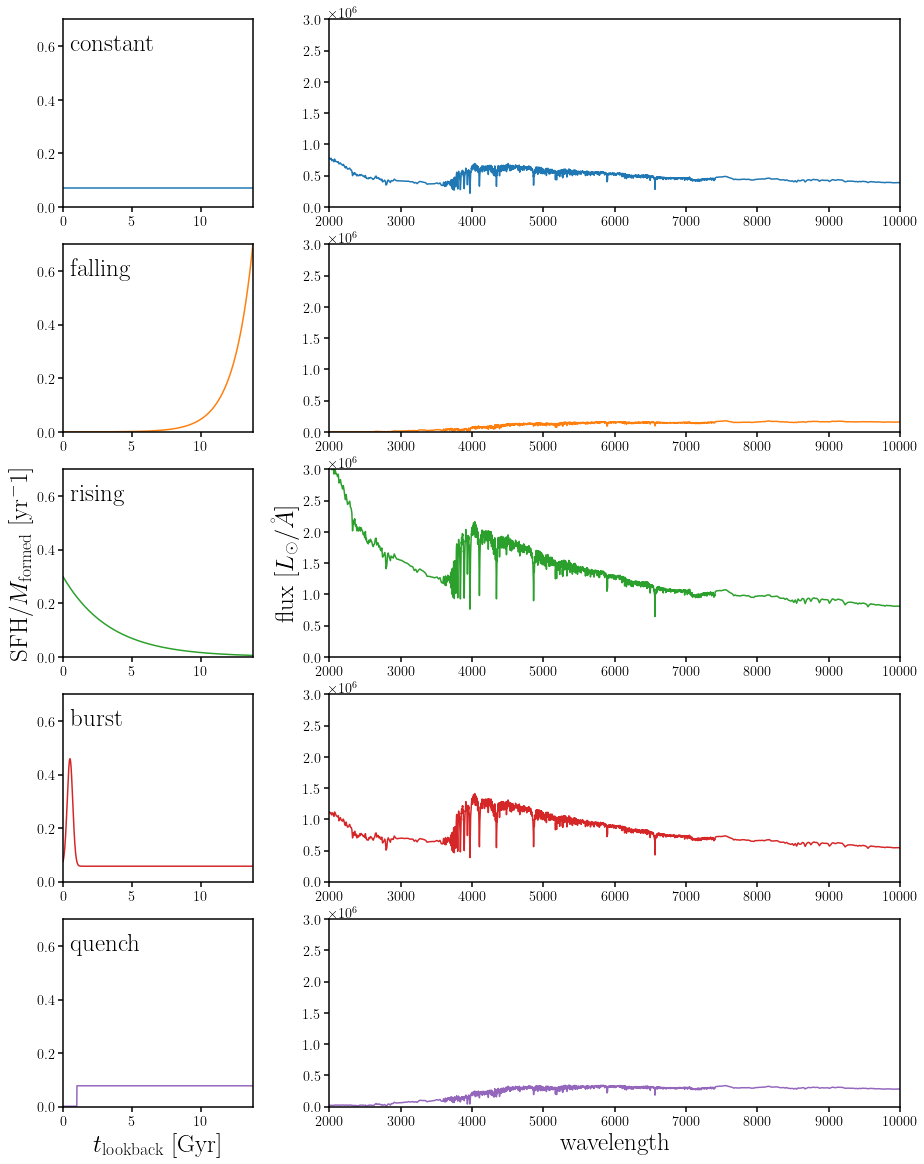

In [66]:
fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(5, 2, width_ratios=[1,3]) 
for i, sfh, sed, lbl in zip(range(5), sfhs, seds, lbls): 
    sub = plt.subplot(gs[i,0])
    sub.plot(tlb, sfh, c='C%i' % i, label=lbl)
    if i == 4: sub.set_xlabel(r'$t_{\rm lookback}$ [Gyr]', fontsize=25)
    sub.set_xlim(0, tage)
    if i == 2: sub.set_ylabel(r'SFH/$M_{\rm formed}$ [${\rm yr}^-1$]', fontsize=25)
    sub.set_ylim(0, 0.7)
    sub.text(0.5, 0.65, lbl, ha='left', va='top', fontsize=25)
    
    sub = plt.subplot(gs[i,1])
    sub.plot(sed[0], sed[1], c='C%i' % i, label=lbl)
    sub.set_xlim(2e3, 1e4)
    sub.set_ylim(0, 3e6)
    if i == 4: sub.set_xlabel('wavelength', fontsize=25)
    if i == 2: sub.set_ylabel(r'flux [$L_\odot/\AA$]', fontsize=25)

# save SFH, wavelengths, SEDs to file

In [69]:
np.save('/Users/chahah/data/provabgs/prior_correct/t.lookback.npy', tlb)
np.save('/Users/chahah/data/provabgs/prior_correct/wave.fsps.npy', sed_constant[0])
for i, sfh, sed, lbl in zip(range(5), sfhs, seds, lbls): 
    np.save('/Users/chahah/data/provabgs/prior_correct/sfh.%s.npy' % lbl, sfh)
    np.save('/Users/chahah/data/provabgs/prior_correct/sed.%s.npy' % lbl, sed[1])